## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix

## Load Data

In [2]:
# Load data
# Assuming running from notebooks/ directory
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
gender_submission = pd.read_csv('../data/gender_submission.csv')

# Quick look
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## Feature Engineering & Preprocessing (Custom Transformer)

In [3]:
import sys
# Add backend directory to path so we can import the shared transformer
sys.path.append(os.path.abspath('../backend'))

from app.transformers import TitanicFeatureEngineer

# Defining Raw Columns to keep
# RESTRICTED to Pclass, Sex, Age, Fare as per user request
raw_features = ['Pclass','Sex','Age','Fare']
target = 'Survived'

X = train_df[raw_features]
y = train_df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

Training Shape: (712, 4)
Testing Shape: (179, 4)


## Build Pipelines

In [4]:
# Define the columns that we Expect AFTER feature engineering

numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Consider removing for Trees if desired, but harmless
])

# Categorical features (produced by engineer or original)
# 'Sex', 'Pclass' are original. 'IsChild', 'MaleChild', 'FareBand' are new.
categorical_features = ['Sex', 'Pclass', 'IsChild', 'MaleChild', 'FareBand']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## Model Training and Tuning

In [5]:
custom_weights = {0: 1, 1: 2}

models = {
    "decision_tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight=custom_weights),
        "params": {
            "classifier__max_depth": [5, 7, 10, 12],
            "classifier__min_samples_split": [2, 10],
            "classifier__min_samples_leaf": [1, 2, 5]
        }
    },
    "logistic_regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000, class_weight=custom_weights),
        "params": {
            "classifier__C": [0.1, 1, 5, 10]
        }
    }
}

# Models directory
MODELS_DIR = '../backend/models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

results = {}

for model_name, config in models.items():
    print(f"\nTraining {model_name}...")
    # Updated Pipeline to include Feature Engineering
    pipeline = Pipeline(steps=[
        ('feature_engineering', TitanicFeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', config["model"])
    ])
    
    # Grid Search
    grid_search = GridSearchCV(pipeline, config["params"], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    
    # Evaluate
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Save Model (now includes the transformer!)
    model_path = os.path.join(MODELS_DIR, f"{model_name}_model.pkl")
    joblib.dump(best_model, model_path)
    print(f"Saved model to {model_path}")
    
    results[model_name] = {
        "model": best_model,
        "accuracy": accuracy,
        "y_pred": y_pred
    }


Training decision_tree...
Best params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Test Accuracy: 0.8156
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179

Saved model to ../backend/models\decision_tree_model.pkl

Training logistic_regression...
Best params: {'classifier__C': 0.1}
Test Accuracy: 0.8101
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       105
           1       0.74      0.82      0.78        74

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.82      0.81      0.81

## Comparison & Visualization

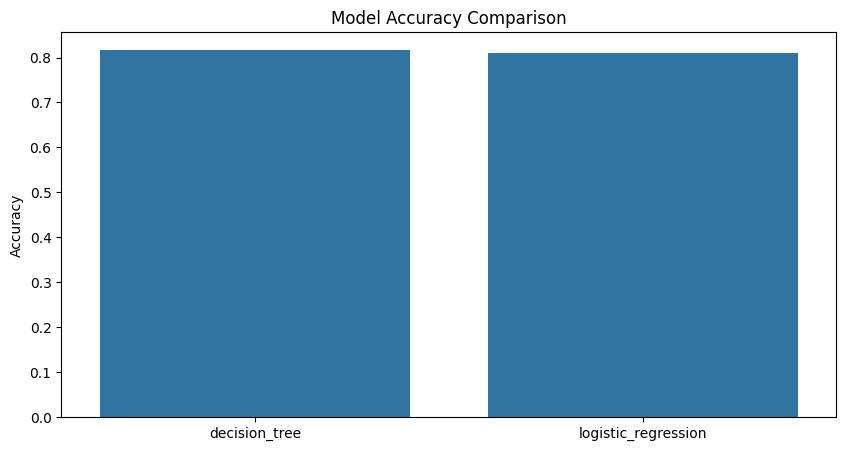

Best Model Overall: decision_tree


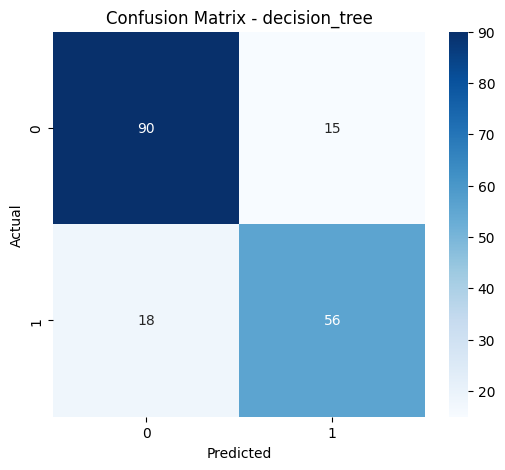

In [6]:
# Note: visualization might need adjustment if using raw X_train/test in some places,
# but results['model'] is a pipeline so it handles raw data.

# Accuracy Comparison
plt.figure(figsize=(10, 5))
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

# Confusion Matrix for Best Model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best Model Overall: {best_model_name}")
best_y_pred = results[best_model_name]['y_pred']

cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()